In [1]:
import math
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib.pyplot as plt
import numpy as np
import random

# This class creates a 8x8 board with a temperature field,
# normalized to have values roughly of the order of -5 to +5,
# changing over time due to the motion of heat sources which have
# a short-ranged influence on the temperature.
#
# An agent is moving over the board; the aim of the agent is to avoid extreme
# temperature zones in order to stay alive. (For that, see the Agent class below.)
#
class Surroundings:
    grid_size = 8  # 8x8 grid like a chessboard
    radius_of_sight = 2  # the agent can see two fields in each direction
    
    _num_heat_sources = 8  # how many heat sources there are on the board
    _v_square_per_source = 0.25  # mean square velocity of the heat sources
    
    _base_temperature = -5    # temperature in the absence of a heat source
    _influence_radius =  2.5  # radius within which an influence of the heat source is perceived
    _temperature_scale = 2.5  # maximum temperature increase due to a single heat source
    
    
    def __init__(self):
        self._debug_output = False
        self._temperature = np.zeros((Surroundings.grid_size, Surroundings.grid_size))
        acceptable_starting_configuration = False
        while not acceptable_starting_configuration:
            self._heat_source_position = [(random.uniform(0, Surroundings.grid_size), \
                                           random.uniform(0, Surroundings.grid_size)) \
                                          for i in range(Surroundings._num_heat_sources)]
            self._compute_temperature()
            self._agent_position = [random.randrange(1, Surroundings.grid_size - 1), \
                                    random.randrange(1, Surroundings.grid_size - 1)]
            T_start = self._temperature[self._agent_position[0], self._agent_position[1]]
            if T_start > -0.2* Surroundings._temperature_scale \
            and T_start < 0.2* Surroundings._temperature_scale:
                acceptable_starting_configuration = True
        self._heat_source_velocity = [(0, 0) for i in range(Surroundings._num_heat_sources)]
        for i in range(Surroundings._num_heat_sources):
            vi0 = random.uniform(0, Surroundings._v_square_per_source)**0.5
            if random.randrange(2) == 1:
                vi0 = -vi0
            vi1 = random.uniform(0, Surroundings._v_square_per_source)**0.5
            if random.randrange(2) == 1:
                vi1 = -vi1
            self._heat_source_velocity[i] = (vi0, vi1)
    
    def _compute_temperature(self):
        for x0 in range(Surroundings.grid_size):
            for x1 in range(Surroundings.grid_size):
                self._temperature[x0, x1] = Surroundings._base_temperature
                for (q0, q1) in self._heat_source_position:
                    distance = ((x0 - q0)**2 + (x1 - q1)**2)**0.5  # distance to heat source
                    if distance < Surroundings._influence_radius:  # add temperature contribution
                        self._temperature[x0][x1] += Surroundings._temperature_scale \
                        * (Surroundings._influence_radius - distance)
    
    def _move_heat_sources(self):
        for i in range(Surroundings._num_heat_sources):
            (qi0, qi1) = self._heat_source_position[i]
            (vi0, vi1) = self._heat_source_velocity[i]
            qi0 += vi0
            if qi0 < 0:  # hard-wall boundary condition in x0 direction
                qi0 = -qi0
                vi0 = -vi0
            if qi0 > Surroundings.grid_size:
                qi0 = 2*Surroundings.grid_size - qi0
                vi0 = -vi0
            qi1 += vi1
            if qi1 < 0:  # hard-wall boundary condition in x1 direction
                qi1 = -qi1
                vi1 = -vi1
            if qi1 > Surroundings.grid_size:
                qi1 = 2*Surroundings.grid_size - qi1
                vi1 = -vi1
            self._heat_source_position[i] = (qi0, qi1)
            self._heat_source_velocity[i] = (vi0, vi1)
        self._compute_temperature()
        if self._debug_output:
            print("Agent at:", self._agent_position, end="\t\t")
            print("Local temperature:", \
                  round(self._temperature[self._agent_position[0], self._agent_position[1]], 2))
    
    def activate_debug_output(self):
        self._debug_output = True
    
    def visualize(self):
        fig, ax = plt.subplots()
        fig.set_size_inches(7, 7)
        plt.xticks(fontsize=18, color="#322300")
        plt.yticks(fontsize=18, color="#322300")
        ax.set_xlabel("coordinate x1", fontsize=24, color="#322300")
        ax.set_ylabel("coordinate x0", fontsize=24, color="#322300")
        im = plt.imshow(self._temperature, extent=[-0.5, Surroundings.grid_size-0.5, \
                                              Surroundings.grid_size-0.5, -0.5])
        cb = plt.colorbar()
        q0 = self._agent_position[0]
        q1 = self._agent_position[1]
        path = Path([[q1, q0+0.5], [q1+0.5, q0], [q1, q0-0.5], [q1-0.5, q0], [q1, q0+0.5]])
        patch = PathPatch(path, facecolor='#ff0000')
        ax.add_patch(patch)
    
    def perceive_local_temperature(self):
        return self._temperature[self._agent_position[0], self._agent_position[1]]
    
    # returns a percept list consisting of the temperature value
    # 0) at the position with x0 increased by one, and 1) with x0 increased by 2
    #
    # if we are at the edge of the board, infinity is returned as the temperature value
    #
    def perceive_temperature_x0_higher(self):
        percept = []
        for i in range(Surroundings.radius_of_sight):
            q0 = self._agent_position[0] + i + 1
            q1 = self._agent_position[1]
            if q0 < Surroundings.grid_size:
                percept.append(self._temperature[q0, q1])
            else:
                percept.append(math.inf)
        return percept
    
    # returns a percept list consisting of the temperature value
    # 0) at the position with x0 decreased by one, and 1) with x0 decreased by 2
    #
    # if we are at the edge of the board, infinity is returned as the temperature value
    #
    def perceive_temperature_x0_lower(self):
        percept = []
        for i in range(Surroundings.radius_of_sight):
            q0 = self._agent_position[0] - i - 1
            q1 = self._agent_position[1]
            if q0 >= 0:
                percept.append(self._temperature[q0, q1])
            else:
                percept.append(math.inf)
        return percept
    
    # returns a percept list consisting of the temperature value
    # 0) at the position with x1 increased by one, and 1) with x1 increased by 2
    #
    # if we are at the edge of the board, infinity is returned as the temperature value
    #
    def perceive_temperature_x1_higher(self):
        percept = []
        for i in range(Surroundings.radius_of_sight):
            q0 = self._agent_position[0]
            q1 = self._agent_position[1] + i + 1
            if q1 < Surroundings.grid_size:
                percept.append(self._temperature[q0, q1])
            else:
                percept.append(math.inf)
        return percept
    
    # returns a percept list consisting of the temperature value
    # 0) the position with x1 decreased by one, and 1) with x1 decreased by 2
    #
    # if we are at the edge of the board, infinity is returned as the temperature value
    #
    def perceive_temperature_x1_lower(self):
        percept = []
        for i in range(Surroundings.radius_of_sight):
            q0 = self._agent_position[0]
            q1 = self._agent_position[1] - i - 1
            if q1 >= 0:
                percept.append(self._temperature[q0, q1])
            else:
                percept.append(math.inf)
        return percept
    
    # agent decides to increase x0 by one
    #
    def action_increment_x0(self):
        if self._agent_position[0] < Surroundings.grid_size - 1:
            self._agent_position[0] += 1
        else:
            print("\tWarning: action_increment_x0 at", self._agent_position, "failed due to wall")
        self._move_heat_sources()
    
    # agent decides to decrease x0 by one
    #
    def action_decrement_x0(self):
        if self._agent_position[0] > 0:
            self._agent_position[0] -= 1
        else:
            print("\tWarning: action_decrement_x0 at", self._agent_position, "failed due to wall")
        self._move_heat_sources()
    
    # agent decides to increase x1 by one
    #
    def action_increment_x1(self):
        if self._agent_position[1] < Surroundings.grid_size - 1:
            self._agent_position[1] += 1
        else:
            print("\tWarning: action_increment_x1 at", self._agent_position, "failed due to wall")
        self._move_heat_sources()
    
    # agent decides to decrease x1 by one
    #
    def action_decrement_x1(self):
        if self._agent_position[1] > 0:
            self._agent_position[1] -= 1
        else:
            print("\tWarning: action_decrement_x1 at", self._agent_position, "failed due to wall")
        self._move_heat_sources()
    
    # agent decides to sit around and do nothing
    #
    def action_wait(self):
        self._move_heat_sources()

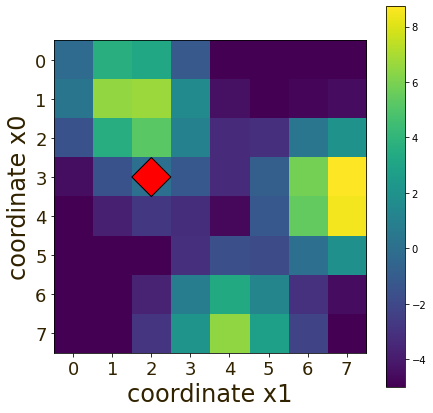

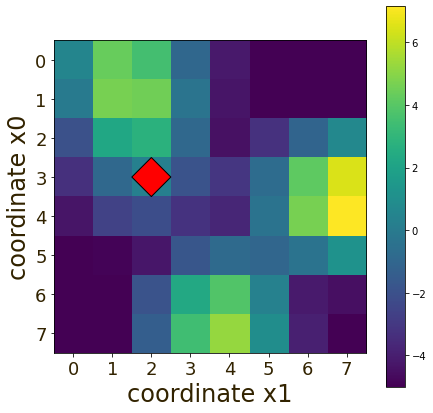

In [2]:
import time

landscape = Surroundings()
landscape.visualize()
for i in range(1):
    landscape._move_heat_sources()
landscape.visualize()

In [3]:
class Agent:
    temperature_tolerance = 4  # if temperature is outside the range from -4 to +4, the agent dies
    
    def __init__(self, landscape):
        self._alive = True
        self._environment = landscape
        self._timestep = 0
    
    # gather percepts
    #
    def sensor_input(self):
        self._local_temperature = self._environment.perceive_local_temperature()
        self._percept_x0_higher = self._environment.perceive_temperature_x0_higher()
        self._percept_x0_lower = self._environment.perceive_temperature_x0_lower()
        self._percept_x1_higher = self._environment.perceive_temperature_x1_higher()
        self._percept_x1_lower = self._environment.perceive_temperature_x1_lower()
        
        # check whether the agent dies due to extreme temperature
        #
        if abs(self._local_temperature) > Agent.temperature_tolerance:
            self._alive = False
    
    # keep gathering percepts and calling the agent function until, eventually, the agent dies
    #
    # the function returns the number of timesteps that it takes until the agent dies
    #
    def live(self):
        self.sensor_input()
        while self._alive:
            self._timestep += 1
            self.agent_function()
            self.sensor_input()
        # print("Agent died after", self._timestep, "steps")
        return self._timestep
            
    
### ****** ONLY THE FUNCTION BELOW SHOULD BE MODIFIED TO IMPROVE THE AGENT'S BEHAVIOUR ****** ### 
    
    # a very basic and straightforward agent function by
    # which the agent wanders around the landscape, trying to
    # avoid zones with extreme temperatures
    #
    def agent_function(self):
        
        # remark:
        #
        # the agent function would be allowed to store percepts so that
        # they can be remembered in the future, etc.; this simple solution
        # does not do that, it only relies on the present percepts
        
        # look for a direction that decreases abs(temperature) and walk there
        #
        # we are using the percept for the temperature two fields away in each direction,
        # e.g., _percept_x0_higher[1] corresponds to the field with x0 increased by 2
        #
        if abs(self._percept_x0_higher[1]) < abs(self._local_temperature):
            self._environment.action_increment_x0()
        elif abs(self._percept_x0_lower[1]) < abs(self._local_temperature):
            self._environment.action_decrement_x0()
        elif abs(self._percept_x1_higher[1]) < abs(self._local_temperature):
            self._environment.action_increment_x1()
        elif abs(self._percept_x1_lower[1]) < abs(self._local_temperature):
            self._environment.action_decrement_x1()
        else:
            self._environment.action_wait()
    
### ****** ONLY THE FUNCTION ABOVE SHOULD BE MODIFIED TO IMPROVE THE AGENT'S BEHAVIOUR ****** ### 

Agent at: [1, 5]		Local temperature: -1.98
Agent at: [2, 5]		Local temperature: -4.41

****
The agent died after 2 steps


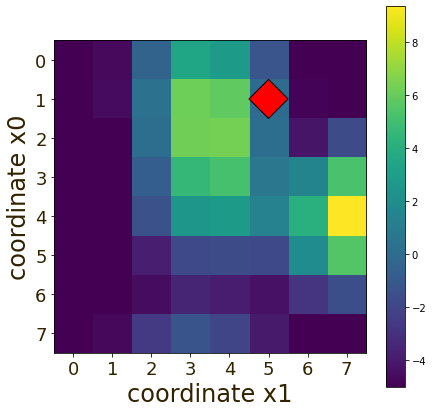

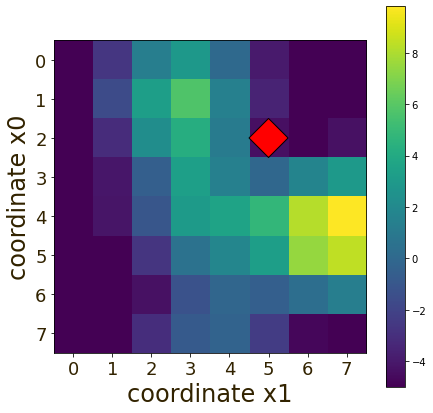

In [9]:
landscape = Surroundings()
landscape.activate_debug_output()
landscape.visualize()

agent = Agent(landscape)
time = agent.live()
print("\n****\nThe agent died after", time, "steps")

landscape.visualize()

In [11]:
repetitions = 5000

total_life = 0
for i in range(repetitions):
    landscape = Surroundings()
    agent = Agent(landscape)
    this_life = agent.live()
    total_life += this_life
    if i%100 == 0:
        print(i, this_life, round(total_life/(i+1), 3), sep="\t")

print("****\nAverage life:", round(total_life/repetitions, 3), "steps")

0	6	6.0
100	19	19.228
200	25	18.289
300	14	18.628
400	18	18.908
500	43	18.729
600	7	18.541
700	15	18.465
800	10	18.557
900	83	18.541
1000	27	18.273
1100	5	18.215
1200	16	18.439
1300	18	18.336
1400	6	18.275
1500	26	18.185
1600	6	18.066
1700	22	18.049
1800	7	18.052
1900	8	18.12
2000	40	18.065
2100	14	18.212
2200	50	18.129
2300	13	18.173
2400	9	18.176
2500	7	18.242
2600	15	18.302
2700	10	18.348
2800	19	18.34
2900	13	18.387
3000	18	18.373
3100	7	18.325
3200	19	18.358
3300	22	18.371
3400	25	18.338
3500	8	18.256
3600	12	18.251
3700	28	18.313
3800	11	18.329
3900	28	18.309
4000	4	18.328
4100	18	18.359
4200	16	18.394
4300	27	18.384
4400	54	18.419
4500	25	18.361
4600	12	18.456
4700	5	18.445
4800	28	18.379
4900	17	18.356
****
Average life: 18.333 steps
